# <a id='toc1_'></a>[Propuesta de experimento](#toc0_)
Creamos un dataset que aglutina toda la información de los ficheros .csv correspondientes a los movimientos de las actividades de todos los sujetos.
Para ello se leen los archivos y se genera el dataset, añadiendo la etiqueta que le corresponde a cada grupo de coordenadas de las distintas articulaciones/huesos.
A partir de aquí, se crean las particiones correspondientes a los conjuntos de train, test y validation que se usarán para entrenar y evaluar la red neuronal a diseñar
para realizar la tarea de clasificación solicitada.

**Tabla de contenidos**<a id='toc0_'></a>    
- [Propuesta de experimento](#toc1_)    
  - [1º - Imports de librerias a utilizar](#toc1_1_)    
  - [2º - Proceso de carga de datos y EDA básico](#toc1_2_)    
  - [3º - Preparación del dataset para la partición de datos](#toc1_3_)    
    - [División del DataFrame en TRAIN, TEST Y VALIDATION](#toc1_3_1_)    
  - [4º - Construcción, entrenamiento y evaluación del clasificador Red Neuronal](#toc1_4_)    
    - [Importamos librerías para la construcción de la Red Neuronal](#toc1_4_1_)    
    - [Diseño modelo arquitectura Red Neuronal](#toc1_4_2_)    
    - [Entrenamiento del modelo](#toc1_4_3_)    
    - [Probando el conjunto de datos en el subset de test y evaluando el performance del modelo](#toc1_4_4_)    
  - [5º - Conclusiones](#toc1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[1º - Imports de librerias a utilizar](#toc0_)

In [1]:
import csv
import pandas as pd
import numpy as np
import tensorflow as tf

2023-08-16 20:00:16.237993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pathlib
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

## <a id='toc1_2_'></a>[2º - Proceso de carga de datos y EDA básico](#toc0_)

In [4]:
data_path="/Users/jordi/Desktop/FORMACION/CODE/phdUVa/videoandimus"
activities=['A01','A02','A03','A04','A05','A06','A07','A08','A09','A10','A11','A12','A13']
subjects=['S40','S41','S42','S44','S46','S47','S48','S49','S50','S51','S52','S53','S54','S55','S56','S57']
data =[]

In [5]:
for activity in activities:
    # for subject in os.listdir(data_path):
    for subject in subjects:
        if subject.startswith('S'):
            for filename in os.listdir(os.path.join(data_path, subject)):
                if filename.startswith(subject + '_'+ activity) and (filename.endswith('_T01.csv') or filename.endswith('_T02.csv')):
                    filepath = os.path.join(data_path, subject, filename)
                    # print(filepath)
                    df = pd.read_csv(filepath, header=0)
                    df['activity'] = activity
                    data.append(df)
dataset = pd.concat(data,ignore_index=True)

In [6]:
print(dataset['activity'].unique())

['A01' 'A02' 'A03' 'A04' 'A05' 'A06' 'A07' 'A08' 'A09' 'A10' 'A11' 'A12'
 'A13']


In [7]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172456 entries, 0 to 172455
Columns: 103 entries, pelvis_x to activity
dtypes: float64(102), object(1)
memory usage: 135.5+ MB
None


In [8]:
print(dataset.dtypes)

pelvis_x              float64
pelvis_y              float64
pelvis_z              float64
left_hip_x            float64
left_hip_y            float64
                       ...   
left_thumb_tip_z      float64
 right_thumb_tip_x    float64
 right_thumb_tip_y    float64
 right_thumb_tip_z    float64
activity               object
Length: 103, dtype: object


In [9]:
# Distribución de las muestras por actividad
print(dataset.shape)
print(dataset.groupby('activity').size())  

(172456, 103)
activity
A01    19082
A02    24372
A03    19936
A04    11827
A05    13298
A06    11358
A07    12778
A08    12493
A09    13637
A10     9045
A11     8757
A12     9073
A13     6800
dtype: int64


La distribución de la información existente en el dataset está muy poco balanceada. Existen muchas muestras de varias clases, mientras que de otras la cantidad de muestras llega a ser casi cuatro veces menor. Esto puede ser foco de problemas a la hora de realizar la tarea de clasificación.

In [10]:
# Búsqueda de valores nulos en el dataset
null_cols = dataset.columns[dataset.isnull().any()]
dataset[null_cols].isnull().sum()
print(dataset[dataset.isnull().any(axis=1)][null_cols].head())

Empty DataFrame
Columns: []
Index: []


## <a id='toc1_3_'></a>[3º - Preparación del dataset para la partición de datos](#toc0_)

Generación de la partición X, y

Preprocesado de los datos 

In [11]:
X=dataset.drop(columns=['activity']) # carga los valores de las muestras para todo el dataset
y=dataset['activity'] # carga las etiquetas de las muestras para todo el dataset

In [12]:
print(X.shape)
print(y.shape)

(172456, 102)
(172456,)


Conversión a numpy array

In [13]:
X= np.array(X) # convierte la lista a un array de numpy
y= np.array(y) # convierte las etiquetas a un array de numpy

Función para recodificación de etiquetas

In [14]:
def labelAssign(textLabel):
    if textLabel == 'A01':
        return 0
    elif textLabel == 'A02':
        return 1
    elif textLabel == 'A03':
        return 2
    elif textLabel == 'A04':
        return 3
    elif textLabel == 'A05':
        return 4
    elif textLabel == 'A06':
        return 5
    elif textLabel == 'A07':
        return 6
    elif textLabel == 'A08':
        return 7
    elif textLabel == 'A09':
        return 8
    elif textLabel == 'A10':
        return 9
    elif textLabel == 'A11':
        return 10
    elif textLabel == 'A12':
        return 11
    elif textLabel == 'A13':
        return 12

In [15]:
y_new=[]
for i in range(len(y)):
    y_new.append(labelAssign(y[i]))


In [16]:
y_new=np.array(y_new)
print(y_new.shape)

(172456,)


### <a id='toc1_3_1_'></a>[División del DataFrame en TRAIN, TEST Y VALIDATION](#toc0_)

In [17]:
validation = 0.15 / (0.25 + 0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y_new, train_size=0.7)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=validation)

In [18]:
X_train, X_test = X_train/255.0, X_test/255.0 # Normalization
y_train = to_categorical(y_train, num_classes=13) # One-hot encoding
y_test = to_categorical(y_test, num_classes=13) # One-hot encoding
y_val=to_categorical(y_val, num_classes=13) # One-hot encoding

In [19]:
print ('El conjunto TRAIN tiene ',X_train.shape[0], ' muestras y ',X_train.shape[1],' variables')
print ('El conjunto TEST tiene ',X_test.shape[0],' muestras y ',X_test.shape[1],' variables')
print ('El conjunto VALIDATION tiene ',X_val.shape[0],' muestras y ',X_val.shape[1],' variables')

El conjunto TRAIN tiene  120719  muestras y  102  variables
El conjunto TEST tiene  32336  muestras y  102  variables
El conjunto VALIDATION tiene  19401  muestras y  102  variables


In [20]:
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(120719, 13)
(32336, 13)
(19401, 13)


## <a id='toc1_4_'></a>[4º - Construcción, entrenamiento y evaluación del clasificador Red Neuronal](#toc0_)

### <a id='toc1_4_1_'></a>[Importamos librerías para la construcción de la Red Neuronal](#toc0_)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Activation, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed, ReLU, Softmax
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2,l1
from keras.callbacks import EarlyStopping
from keras.layers import PReLU
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

### <a id='toc1_4_2_'></a>[Diseño modelo arquitectura Red Neuronal](#toc0_)

In [22]:
clases = 13 # Número de clases a predecir
model = Sequential()
model.add(Dense(102,input_dim =102, activation = 'relu'))
model.add(Dropout(0))
model.add(Dense(50,activation='relu'))
model.add(Dropout(0))
model.add(Dense(25,activation='relu'))
model.add(Dropout(0))
model.add(Dense(clases, name='y_pred', activation='softmax'))

2023-08-16 20:04:58.905437: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 102)               10506     
                                                                 
 dropout (Dropout)           (None, 102)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5150      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                                 
 y_pred (Dense)              (None, 13)                3

In [24]:
train_params={
    'epochs' :100,
    'batch_size': 32,
    'verbose': 1
}

In [25]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

### <a id='toc1_4_3_'></a>[Entrenamiento del modelo](#toc0_)

In [26]:
H = model.fit(X_train, y_train, **train_params)

Epoch 1/100
3773/3773 [==============================] - 5s 1ms/step - loss: 1.0192 - accuracy: 0.5390
Epoch 2/100
3773/3773 [==============================] - 5s 1ms/step - loss: 0.7453 - accuracy: 0.6449
Epoch 3/100
3773/3773 [==============================] - 5s 1ms/step - loss: 0.6826 - accuracy: 0.6791
Epoch 4/100
3773/3773 [==============================] - 5s 1ms/step - loss: 0.6385 - accuracy: 0.7027
Epoch 5/100
3773/3773 [==============================] - 5s 1ms/step - loss: 0.6068 - accuracy: 0.7188
Epoch 6/100
3773/3773 [==============================] - 5s 1ms/step - loss: 0.5790 - accuracy: 0.7327
Epoch 7/100
3773/3773 [==============================] - 5s 1ms/step - loss: 0.5614 - accuracy: 0.7407
Epoch 8/100
3773/3773 [==============================] - 5s 1ms/step - loss: 0.5450 - accuracy: 0.7500
Epoch 9/100
3773/3773 [==============================] - 5s 1ms/step - loss: 0.5287 - accuracy: 0.7589
Epoch 10/100
3773/3773 [==============================] - 5s 1ms/step - l

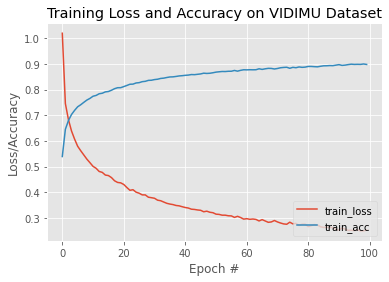

In [27]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.title("Training Loss and Accuracy on VIDIMU Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")

### <a id='toc1_4_4_'></a>[Probando el conjunto de datos en el subset de test y evaluando el performance del modelo](#toc0_)

In [28]:
from sklearn.metrics import classification_report
# Evaluando modelo de predicción
predicciones = model.predict(X_test, batch_size=32, verbose=1)
print (y_test[0])
print (predicciones[0])
print (classification_report(y_test.argmax(axis=1), predicciones.argmax(axis=1)))

1011/1011 [==============================] - 1s 930us/step
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[2.3473261e-02 8.8395804e-01 9.2568725e-02 0.0000000e+00 1.5972048e-33
 0.0000000e+00 3.6193761e-33 1.2536413e-33 5.1435100e-23 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00]
              precision    recall  f1-score   support

           0       0.86      0.65      0.74      3543
           1       0.80      0.90      0.85      4561
           2       0.85      0.93      0.89      3802
           3       1.00      1.00      1.00      2248
           4       0.95      0.93      0.94      2458
           5       0.97      0.94      0.95      2143
           6       0.92      0.97      0.94      2428
           7       0.95      0.95      0.95      2366
           8       0.96      0.96      0.96      2500
           9       0.99      0.98      0.99      1706
          10       0.93      0.99      0.96      1614
          11       0.99      0.93      0.96      1698
          1

## <a id='toc1_5_'></a>[5º - Conclusiones](#toc0_)

Analizando los valores de las métricas obtenidas se observa que:  
- ***Precisión***: se obtiene una muy buena media a nivel global y, a nivel individual también se alcanzan, salvo en las tres primeras clases, valores por encima del 90% de aciertos. Esto indica, por tanto, que no se detectan practicamente los falsos positivos. Por tanto, el sistema es altamente preciso al detectar las coordenadas de los distintos puntos de interés.   

- ***Recall (Sensibilidad)***: en este apartado, en la clase 0 (A01) se observa un valor ligeramente bajo, 65%, lo que nos indica que en esta actividad el nivel de predicción no es excesivamente bueno. En el resto de clases, y en el valor medio de esta métrica, se supera el 90%, con lo que el número de aciertos verdaderos sobre los que realmente lo son es también satisfactorio. Por tanto, el nivel de sensibilidad del sistema es satisfactorio y, teniendo en cuenta los valores de la métrica anterior, nos indica que este modelo es altamente fiable y preciso.     

- ***F1 Score***: el valor volcado por esta métrica, que como sabemos se trata de la media armónica entre las dos métricas anteriores, viene a constatar lo citado hasta este punto.     
   
En resumen, el modelo de clasificador basado en una red neuronal que se ha desarrollado en el presente experimento es bastante preciso y fiable a la hora de establecer a que actividad pertenece un conjunto de coordenadas correspondiente a una determinada posición del cuerpo de un sujeto, tomadas a través de un grupo de sensores colocados en distintos puntos de interés del citado sujeto.    

Estos resultados podrían mejorarse realizando un análisis más detallado y profundo de los distintos valores que pueden tomar los hiperparámetros del modelo, llegando probablemente a un nivel de precisión algo mayor. También sería necesario disponer de un conjunto de datos más equilibrado, es decir, disponer de un número de muestras equivalente para todas las muestras de las distintas clases.